# Pimchanok (Pim) Khaophuthai
# Titanic Datset (Kaggle)

The propose of this project is to develop models predicting who will survive the sinking of the Titanic. 

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Modeling libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report,\
precision_score, recall_score, roc_auc_score, roc_curve, f1_score

warnings.filterwarnings('ignore')

# Load data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Exploration

It is always a good start to descriptively explore the data searching for potential problems or pattern in the dataset. To See what the data looks like and what is in the data.



In [4]:
# see the shape of the data
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [5]:
# See the first few rows of the train dataset
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# See unique values for each columns
print("Pclass",train['Pclass'].unique())
print("Sex",train['Sex'].unique())
print("SibSp", train['SibSp'].unique())
print("Parch", train['Parch'].unique())
print("Embarked", train['Embarked'].unique())
print("Range for Age", min(train['Age']), '-' ,max(train['Age']))
print("Range for fare", min(train['Fare']), '-' , max(train['Fare']))

Pclass [3 1 2]
Sex ['male' 'female']
SibSp [1 0 3 4 2 5 8]
Parch [0 1 2 5 3 4 6]
Embarked ['S' 'C' 'Q' nan]
Range for Age 0.42 - 80.0
Range for fare 0.0 - 512.3292


There are categorical features in text format, `Sex` and `Embarked`. Text data in `Name` and mixed data type (numeric and text) in `Cabin` and `Ticket`

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Bowen, Mr. David John ""Dai""",male,1601,G6,S
freq,1,577,7,4,644


- `Survived` is an categorical feature with possible values of 0 and 1. The mean shows that 38% of the passenger in the dataset survived the sinking
- More than 70% of passengers did not travel with parents or children (Parch)
- The oldest passenger was at age of 80. The average of passenger in the ship was 29 years old. There were not many elderly passenger as at 75% the passengers' age was less than 38
- There were more male passengers than female
- There were 3 places of embarked with S as the highest location where most of passenger embarked at
- Name is unique

In [9]:
# See the distribution of Survived
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Finding Correlation

Before fitting any sample to any model, it is helpful to explore the relationship between the features and the target variable

### Categorical Data

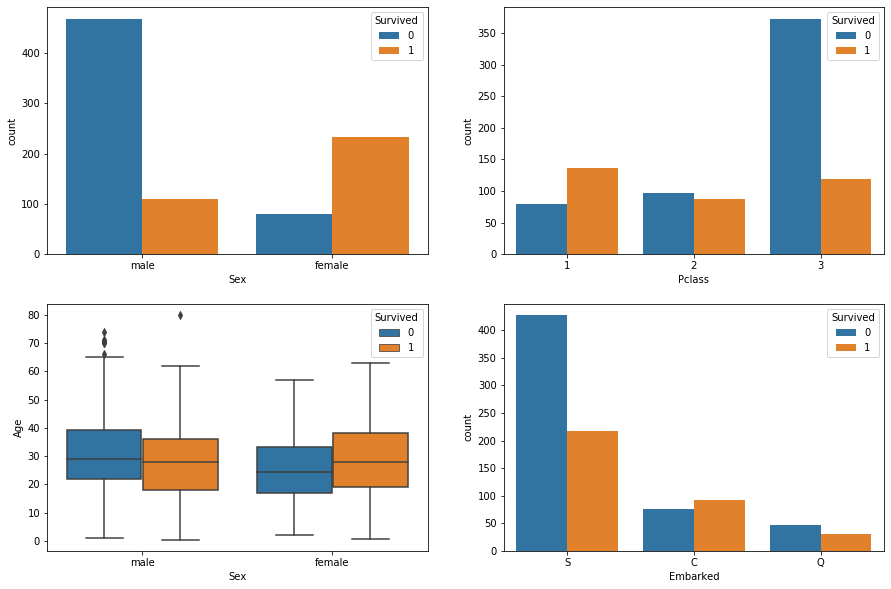

In [10]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

ax1 = plt.subplot(2,2,1)
ax1 = sns.countplot(x='Sex', hue='Survived', data=train)

ax2 = plt.subplot(2,2,2)
ax2 = sns.countplot(x='Pclass', hue = 'Survived', data = train)

ax3 = plt.subplot(2,2,3)
ax3 = sns.boxplot(x='Sex', y='Age', hue='Survived', data=train)

ax4 = plt.subplot(2,2,4)
ax4 = sns.countplot(x='Embarked', hue='Survived', data= train)


- In term of `Sex`, female had a higher rate of survival
- Class 1 and 2 had higher chance of survival the sink. Class 3 had low rate of survival
- Age does not seem to be different among those who survived and those who not
- Embarked at C tends to have highe chance of survival

In [11]:
train[['Sex','Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
train[['Pclass','Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [13]:
train[['Embarked','Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


The calculations support the findings found above

### Numerical Data

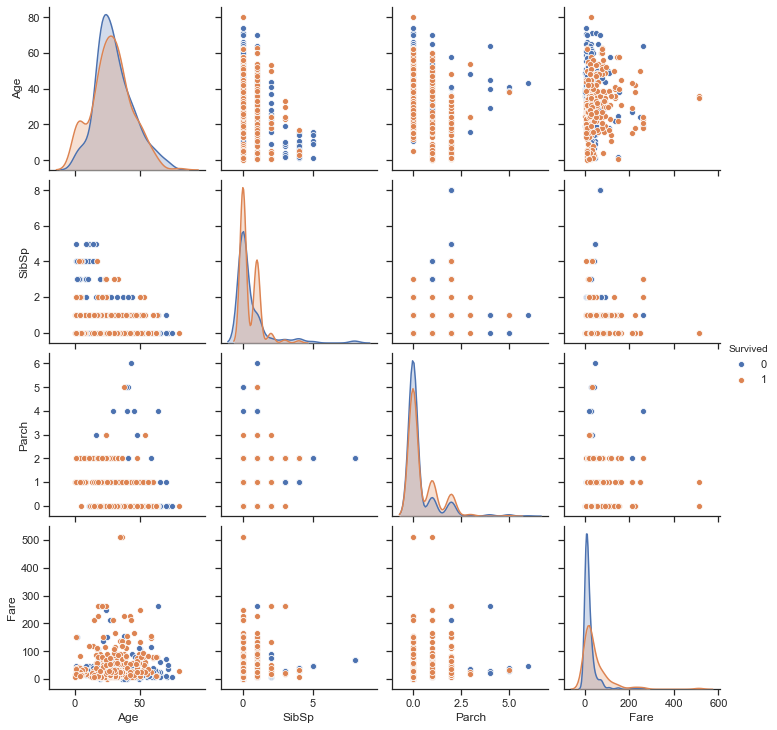

In [14]:
sns.set(style="ticks")
sns.pairplot(train.drop(['PassengerId','Name','Ticket','Cabin','Embarked','Pclass'], axis=1) , hue="Survived")

- Younger passengers had better survival rate
- Mid age passengers did not survive
- Most people were in their 15-40
- Higher fare had better chance surviving

## Missing values

In [15]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are missing values in 3 columns `Age`, `Cabin`, and `Embarked`.

In [16]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

`Cabin` and `Age` contain missing values

Apparently, `Cabin` contains more than 50% missing values. The column will be dropped later as replacing all the missing value is not ideal. `Age`, `Embarked` and `Fare` missing values will dealth differently based on the characteristics found in exploration. 

### Dealing with missing values

- Embark, since there are only 2 missing data in Embark, they will be dropped
- Cabin has more than 50% of missing value, the column will be dropped
- Age, a lot of records has missing age therefore it doesn't make sense to drop all of them

In [17]:
train = train[train['Embarked'].notnull()]
train = train.drop(['Cabin'], axis=1)

In [18]:
# Filter the data to only consider those with notnull age
age = train[train['Age'].notnull()]

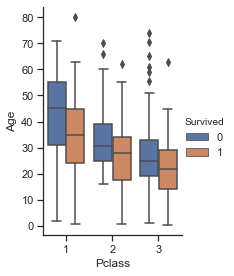

In [19]:
g = sns.catplot(x="Pclass", y="Age",
                hue="Survived",
                data=age, kind="box",
                height=4, aspect=.7);

Older people tend to be in higher class and survived. The missing age will be replaced based on  `Pclass` and `Survived`

In [20]:
# See how age is different among class
age.groupby(['Pclass','Survived'])['Age'].agg(np.median)

Pclass  Survived
1       0           45.25
        1           35.00
2       0           30.50
        1           28.00
3       0           25.00
        1           22.00
Name: Age, dtype: float64

In [21]:
# Replace missing age based on class using median
for i in range(0,2):
    for j in range(0,3):
        age_ref = train[(train['Pclass']== j+1) & (train['Survived']== i)]["Age"].dropna()
        age_rep = age_ref.median()
    
        index = train[ (train['Age'].isnull()) & (train['Pclass'] == j+1) & (train['Survived'] == i)]["Age"].index
        train['Age'].loc[index] = age_rep

In [22]:
# Check missin values
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Dealing with Text Data

`Name` is pure text data. However, it contains some information that can be extracted and potentially helps in predicting survival

In [23]:
# A function to extract title from name 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [24]:
# Get title from name column
train['title'] = train['Name'].apply(get_title)

In [25]:
train['title'].value_counts()

Mr          517
Miss        181
Mrs         124
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Don           1
Ms            1
Lady          1
Mme           1
Countess      1
Capt          1
Jonkheer      1
Sir           1
Name: title, dtype: int64

There were some common titles where high frequency is observed. And there were those title with rare occurrences. The rare title will be classified as rare so the catergory in title features is reduced.

In [26]:
# Rename rare title
train['title'] = train['title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                         'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
# Correcting typo
train['title'] = train['title'].replace('Mlle', 'Miss')
train['title'] = train['title'].replace('Ms', 'Miss')
train['title'] = train['title'].replace('Mme', 'Mrs')


In [27]:
# Check title as survival rate
train[['title','Survived']].groupby(['title'], as_index=False).mean()

,title,Survived
0,Master,0.575000
1,Miss,0.701087
2,Mr,0.156673
3,Mrs,0.792000
4,Rare,0.347826


Female titles show higher rate of survival which again support the previous finding. Rare and Master title have better rate of survival than male

# Preprocessing

The data will be engineered according to the observations found previously. String variables will be converted to numerical
- `Fare` and `Age` as a continuous variable will be binned and labeled indicating each bin
- `title` as text data type will be labeled

In [28]:
# cutting continuous variable in to bins
train['fare_range'] = pd.qcut(train['Fare'],4)
train['age_range'] = pd.cut(train['Age'], 5)

In [29]:
# Categorical labeling
train['age_code'] = LabelEncoder().fit_transform(train['age_range'])
train['fare_code'] = LabelEncoder().fit_transform(train['fare_range'])

In [30]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train['title'] = train['title'].map(title_mapping)

In [31]:
features = ['Pclass','Sex', 'Embarked','title']
train_model = pd.get_dummies(train, columns=features)

### Dropping the unwanted columns

In [32]:
col_drop = ['PassengerId','Survived','Name','Ticket', 'Fare', 'Age','fare_range','age_range']
y = train_model['Survived']
X = train_model.drop(col_drop, axis=1)

### Spliting Data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   random_state=7)

In [34]:
# Checking the size of the dataframe
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(622, 17) (622,)
(267, 17) (267,)


In [35]:
X_train.head()

,SibSp,Parch,age_code,fare_code,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,title_1,title_2,title_3,title_4,title_5
192,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0
317,0,0,3,1,0,1,0,0,1,0,0,1,0,0,0,0,1
290,0,0,1,3,1,0,0,1,0,0,0,1,0,1,0,0,0
133,1,0,1,2,0,1,0,1,0,0,0,1,0,0,1,0,0
286,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0


# Models

### Logistic Regression

In [38]:
logreg = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

In [39]:
prediction = logreg.predict(X_test)

In [40]:
print("Train set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

print('f1_score {:.4f}'.format(f1_score(y_test,prediction)))

Train set score: 0.830
Test set score: 0.828
f1_score 0.7830


In [41]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       160
           1       0.79      0.78      0.78       107

    accuracy                           0.83       267
   macro avg       0.82      0.82      0.82       267
weighted avg       0.83      0.83      0.83       267



### Random Forest

In [46]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=9, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=9, verbose=1,
                       warm_start=False)

In [47]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 214
Average maximum depth 13


In [48]:
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [49]:
def evaluate_model(predictions, probs, train_predictions, train_probs, train_labels,test_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.82 Train: 0.82
Precision Baseline: 0.4 Test: 0.8 Train: 0.88
Roc Baseline: 0.5 Test: 0.89 Train: 0.95


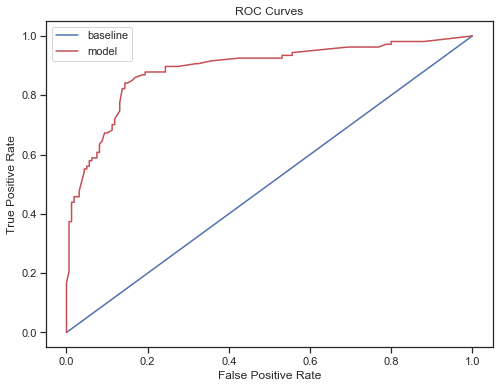

In [50]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions,\
               train_rf_probs, y_train, y_test)


In [51]:
confusion_matrix(y_test, rf_predictions, labels=[0,1])

array([[138,  22],
       [ 19,  88]])

In [52]:
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       160
           1       0.80      0.82      0.81       107

    accuracy                           0.85       267
   macro avg       0.84      0.84      0.84       267
weighted avg       0.85      0.85      0.85       267



In [53]:
print('f1_score {:.4f}'.format(f1_score(y_test,rf_predictions)))

f1_score 0.8111


### Random Forest with Optimization through Random Search

In [54]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10,200).astype(int),
    'max_depth': [None] + list(np.linspace(3,20).astype(int)),
    'max_features':['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10,50,500).astype(int)),
    'min_samples_split':[2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state=9)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs= -1,
                       scoring= 'roc_auc', cv=3, n_iter=10, verbose=1, random_state=9)

# Fit
rs.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [55]:
rs.best_params_

{'n_estimators': 29,
 'min_samples_split': 2,
 'max_leaf_nodes': 35,
 'max_features': 'auto',
 'max_depth': 6,
 'bootstrap': False}

From the random search we can see that the best hyperparameter values are not the defaults. 

In [56]:
rf_best = rs.best_estimator_

In [57]:
train_rfbest_predictions = rf_best.predict(X_train)
train_rfbest_probs = rf_best.predict_proba(X_train)[:, 1]

rfbest_predictions = rf_best.predict(X_test)
rfbest_probs = rf_best.predict_proba(X_test)[:, 1]

In [58]:
n_nodes = []
max_depths = []

for ind_tree in rf_best.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 68
Average maximum depth 6


Recall Baseline: 1.0 Test: 0.71 Train: 0.71
Precision Baseline: 0.4 Test: 0.84 Train: 0.9
Roc Baseline: 0.5 Test: 0.9 Train: 0.91


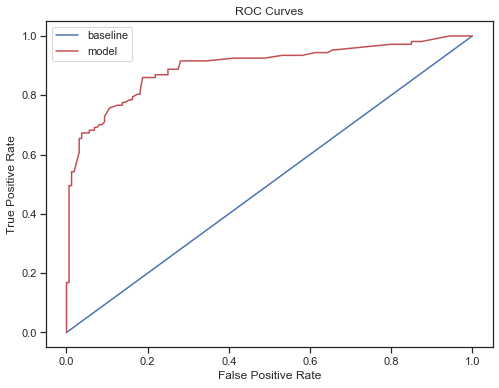

In [59]:
evaluate_model(rfbest_predictions, rfbest_probs, train_rfbest_predictions, train_rfbest_probs, train_labels=y_train, test_labels=y_test)

In [60]:
print('f1_score {:.4f}'.format(f1_score(y_test,rfbest_predictions)))

f1_score 0.7677


# Prediction on Test dataset

In [61]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [62]:
test = test.drop(['Cabin'], axis=1)

In [63]:
for i in range(0,2):
    for j in range(0,3):
        age_ref = test.loc[test['Pclass']== j+1,"Age"].dropna()
        age_rep = age_ref.median()
    
        index = test.loc[(test['Age'].isnull()) & (test['Pclass'] == j+1),"Age"].index
        test.loc[index,'Age'] = age_rep

In [64]:
test.loc[test['Fare'].isnull(),'Fare'] = test.loc[(test['Pclass']==3) & (test['Embarked']=='S'), 'Fare'].median()

In [65]:
test['title'] = test['Name'].apply(get_title)

In [66]:
test['title'] = test['title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                         'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

test['title'] = test['title'].replace('Mlle', 'Miss')
test['title'] = test['title'].replace('Ms', 'Miss')
test['title'] = test['title'].replace('Mme', 'Mrs')


In [67]:
test['title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: title, dtype: int64

In [68]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
title          0
dtype: int64

In [69]:
# cutting continuous variable in to bins
test['fare_range'] = pd.qcut(test['Fare'],4)
test['age_range'] = pd.cut(test['Age'], 5)

# Categorical labeling
test['age_code'] = LabelEncoder().fit_transform(test['age_range'])
test['fare_code'] = LabelEncoder().fit_transform(test['fare_range'])

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
test['title'] = test['title'].map(title_mapping)

features = ['Pclass','Sex', 'Embarked', 'title']
test_model = pd.get_dummies(test, columns=features)

In [70]:
col_drop = ['PassengerId','Name','Ticket', 'Fare', 'Age','fare_range','age_range']
PassengerId = test['PassengerId']
test_model.drop(col_drop, inplace=True, axis = 1)

In [75]:
rf_predictions_test = rf_best.predict(test_model)

In [76]:
rf_predictions_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [77]:
submission = pd.concat([PassengerId, pd.Series(rf_predictions_test)], keys=['PassengerId','Survived'],axis=1)

In [78]:
submission.to_csv('titanic_submission.csv',index=False)

# Conclusion

There are two models built in this project which are Logistic Regression and Random Forest. Two random forest models are built with the difference in hyperparameter. Comparing f1 score, the final model is the first random forest model with f1 score of 0.81. After submitting to Kaggle, the score is 0.77511.

In completing this project, I have refered to the notebook https://www.kaggle.com/startupsci/titanic-data-science-solutions

<b>Reference</b><br>
Sehgal, M. (n.d). Titanic Data Science Solutions. Kaggle
Retrieved from https://www.kaggle.com/startupsci/titanic-data-science-solutions